## Integrated data Kinchen et al. (2018) and Smillie et al. (2019)

In [1]:
%matplotlib inline

In [2]:
import scanpy as sc
import anndata as ad
import scanpy.external as sce
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import warnings
import seaborn as sns
from scipy.signal import find_peaks
import pandas as pd

In [3]:
magma = plt.cm.get_cmap('magma', 256)
magma_colors = magma(np.linspace(0, 1, 256))
grey = np.array([[0.8, 0.8, 0.8, 1.0]])
new_colors = np.vstack((grey, magma_colors[20:])) 
custom_cmap1 = ListedColormap(new_colors)

/tmp/ipykernel_175594/20741051.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  magma = plt.cm.get_cmap('magma', 256)


In [4]:
def condition_stacked_bar_plot(adata, cluster, condition, save=''):
    condition_counts = pd.crosstab(adata.obs[cluster], adata.obs[condition])
    condition_counts['pct_HC'] = 100 * condition_counts['HC'] / (condition_counts['HC'] + condition_counts['UC'])
    condition_counts['pct_UC'] = 100 * condition_counts['UC'] / (condition_counts['HC'] + condition_counts['UC'])
    clusters = condition_counts.index
    pct_HC = condition_counts['pct_HC']
    pct_UC = condition_counts['pct_UC']
    plt.figure(figsize=(10, 6))
    plt.bar(clusters, pct_HC, label='Healthy', color='#F7E7CE')
    plt.bar(clusters, pct_UC, bottom=pct_HC, label='IBD', color='#BFD7ED')
    plt.ylabel('Percentage')
    plt.xlabel('Cluster')
    plt.title('Percentage of Healthy vs Disease Cells per Cluster')
    plt.legend()
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    if save != '':
        plt.savefig(save, dpi=300, bbox_inches='tight')
    plt.show()

In [5]:
#THIS ASSUMES ADATA.RAW IS LOG-TRANSFORMED
def get_deg_table(adata, groupby='leiden', cluster=None):
    sc.tl.rank_genes_groups(adata, groupby=groupby, method='wilcoxon', use_raw=True)
    degs = sc.get.rank_genes_groups_df(adata, group=cluster, pval_cutoff=None)
    degs = degs.rename(columns={
        'names': 'gene',
        'logfoldchanges': 'log2FoldChange',
        'pvals': 'pvalue',
        'pvals_adj': 'padj',
        'scores': 'stat'
    })
    return degs[['gene', 'log2FoldChange', 'stat', 'pvalue', 'padj']]

In [6]:
#THIS ASSUMES ADATA.RAW IS LOG-TRANSFORMED
def get_deg_table_with_cluster_column(adata, groupby='leiden', cluster=None):
    sc.tl.rank_genes_groups(adata, groupby=groupby, method='wilcoxon', use_raw=True)
    degs = sc.get.rank_genes_groups_df(adata, group=None, pval_cutoff=None)
    degs = degs.rename(columns={
        'group': 'group',
        'names': 'gene',
        'logfoldchanges': 'log2FoldChange',
        'pvals': 'pvalue',
        'pvals_adj': 'padj',
        'scores': 'stat'
    })
    return degs[['group', 'gene', 'log2FoldChange', 'stat', 'pvalue', 'padj']]

In [7]:
adata1 = sc.read_h5ad('kinchen.h5ad')
adata2 = sc.read_h5ad('smillie1.h5ad')

In [8]:
adata1.X = np.expm1(adata1.X)

In [9]:
sc.pp.normalize_total(adata2, target_sum=10000)

In [10]:
adata_combined = sc.concat([adata1, adata2], 
                           label='study', 
                           keys=['Kinchen et al. (2018)', 'Smillie et al. (2019)'],
                          )

In [11]:
adata_combined.var['mt'] = adata_combined.var_names.str.startswith("MT")
sc.pp.calculate_qc_metrics(
    adata_combined,
    qc_vars=['mt'],
    percent_top=None,
    log1p=False,
    inplace=True
)

In [12]:
adata_combined = adata_combined[adata_combined.obs['pct_counts_mt']<5]
sc.pp.filter_genes(adata_combined, min_cells=10)
sc.pp.log1p(adata_combined)

/home/nim-lab/miniconda3/envs/dow3/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [13]:
sc.pp.highly_variable_genes(
    adata_combined,
    flavor='seurat',
    batch_key='batch',
    n_top_genes=2500
)
adata_combined.raw = adata_combined.copy()
adata_combined = adata_combined[:, adata_combined.var.highly_variable].copy()

/home/nim-lab/miniconda3/envs/dow3/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


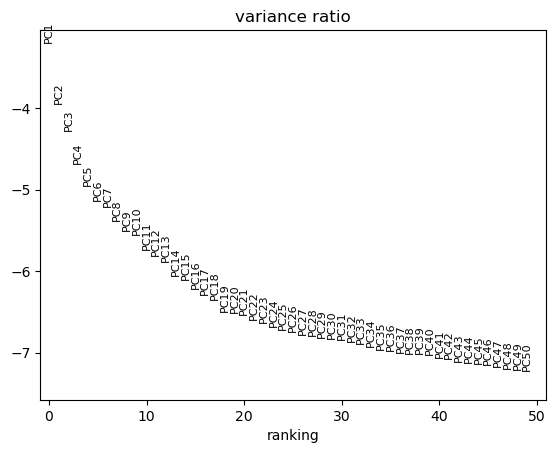

In [14]:
sc.pp.scale(adata_combined, max_value=10)
sc.tl.pca(adata_combined, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_combined, log=True, n_pcs = 50)

In [15]:
sc.external.pp.harmony_integrate(adata_combined, key='batch')
sc.pp.neighbors(adata_combined, n_neighbors = 30, n_pcs = 50, use_rep='X_pca_harmony')
sc.tl.umap(adata_combined, random_state=1)

2025-07-04 10:20:37,728 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-07-04 10:20:40,340 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-07-04 10:20:40,434 - harmonypy - INFO - Iteration 1 of 10
2025-07-04 10:20:44,880 - harmonypy - INFO - Iteration 2 of 10
2025-07-04 10:20:48,670 - harmonypy - INFO - Iteration 3 of 10
2025-07-04 10:20:53,227 - harmonypy - INFO - Iteration 4 of 10
2025-07-04 10:20:57,695 - harmonypy - INFO - Iteration 5 of 10
2025-07-04 10:21:02,140 - harmonypy - INFO - Iteration 6 of 10
2025-07-04 10:21:05,335 - harmonypy - INFO - Iteration 7 of 10
2025-07-04 10:21:09,205 - harmonypy - INFO - Iteration 8 of 10
2025-07-04 10:21:11,271 - harmonypy - INFO - Iteration 9 of 10
2025-07-04 10:21:12,793 - harmonypy - INFO - Converged after 9 iterations


In [16]:
sc.tl.leiden(adata_combined, resolution=0.6)

/tmp/ipykernel_175594/1983668068.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_combined, resolution=0.6)


In [ ]:
sc.pl.umap(adata_combined,color='leiden')

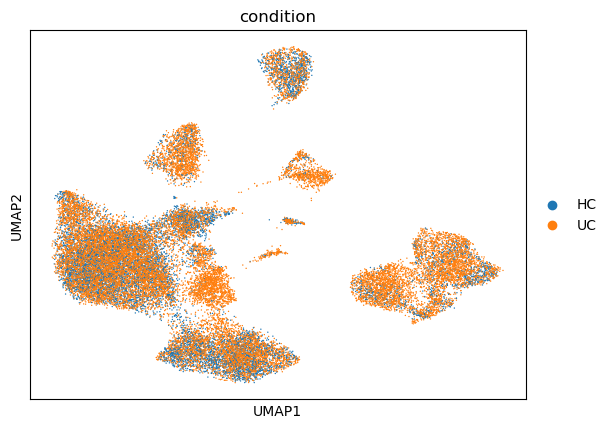

In [32]:
sc.pl.umap(adata_combined, color=['condition'], use_raw=True)

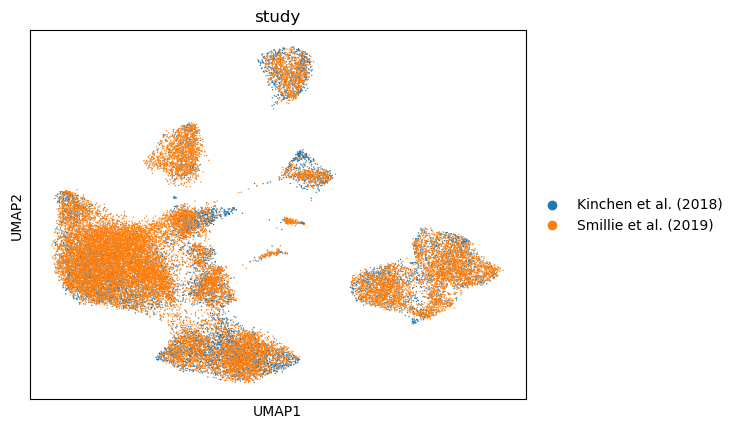

In [33]:
sc.pl.umap(adata_combined, color=['study'], use_raw=True)

condition_stacked_bar_plot(adata_combined, 'celltype', 'condition', save='celltype_condition.png')

In [18]:
smillie_deg = pd.read_excel('1-s2.0-S0092867419307329-mmc2.xlsx', sheet_name='Stromal')

In [19]:
marker_genes = {}
for celltype in smillie_deg.loc[:, 'ident'].unique(): 
    marker_genes[celltype] = smillie_deg.loc[smillie_deg['ident'] == celltype, 'gene'].head(5).tolist()

In [20]:
marker_genes['FOS'] = ['FOS']

In [21]:
marker_genes['F.Endothelial'] = ['SPOCK1', 'FAM110D', 'RAMP3', 'VWF']
marker_genes['Post-capillary Venules'] = ['CLDN5', 'ZNF385D', 'SELP', 'MADCAM1']

In [22]:
marker_genes

{'Endothelial': ['PLVAP', 'CLDN5', 'SEMA3G', 'RBP7', 'MMRN2'],
 'F.Crypt': ['CCL7', 'CFD', 'SHISA3', 'SFTA1P', 'IGFBP7'],
 'F.Endothelial': ['SPOCK1', 'FAM110D', 'RAMP3', 'VWF'],
 'F.Fibroblast': ['SPOCK1', 'SFTA1P', 'PTGFR', 'ELANE', 'HSD11B1'],
 'F.Stromal': ['FAM110D', 'ZNF385D', 'EHD2', 'TEK', 'NKX2-3'],
 'F.Villus': ['REEP2', 'CBLN2', 'GLP2R', 'VSTM2A', 'ENHO'],
 'Inflammatory Fibroblasts': ['IGFBP7', 'LUM', 'C1S', 'CHI3L1', 'LGALS1'],
 'Microvascular': ['PLVAP', 'IGFBP7', 'GNG11', 'RAMP3', 'VWF'],
 'Myofibroblasts': ['ACTA2', 'ACTG2', 'CNN1', 'MYH11', 'TAGLN'],
 'Pericytes': ['RGS5', 'COX4I2', 'HIGD1B', 'IGFBP7', 'NOTCH3'],
 'Post-capillary Venules': ['CLDN5', 'ZNF385D', 'SELP', 'MADCAM1'],
 'RSPO3+': ['LUM', 'DCN', 'IGFBP7', 'OGN', 'GREM2'],
 'WNT2B+ Fos-hi': ['IGFBP7', 'ADAMDEC1', 'CFD', 'APOE', 'DCN'],
 'WNT2B+ Fos-lo 1': ['APOE', 'DCN', 'IGFBP7', 'ADAMDEC1', 'CFD'],
 'WNT2B+ Fos-lo 2': ['APOE', 'CFD', 'IGFBP7', 'DCN', 'ADAMDEC1'],
 'WNT5B+ 1': ['CXCL14', 'MATN3', 'HAS1', 'POS

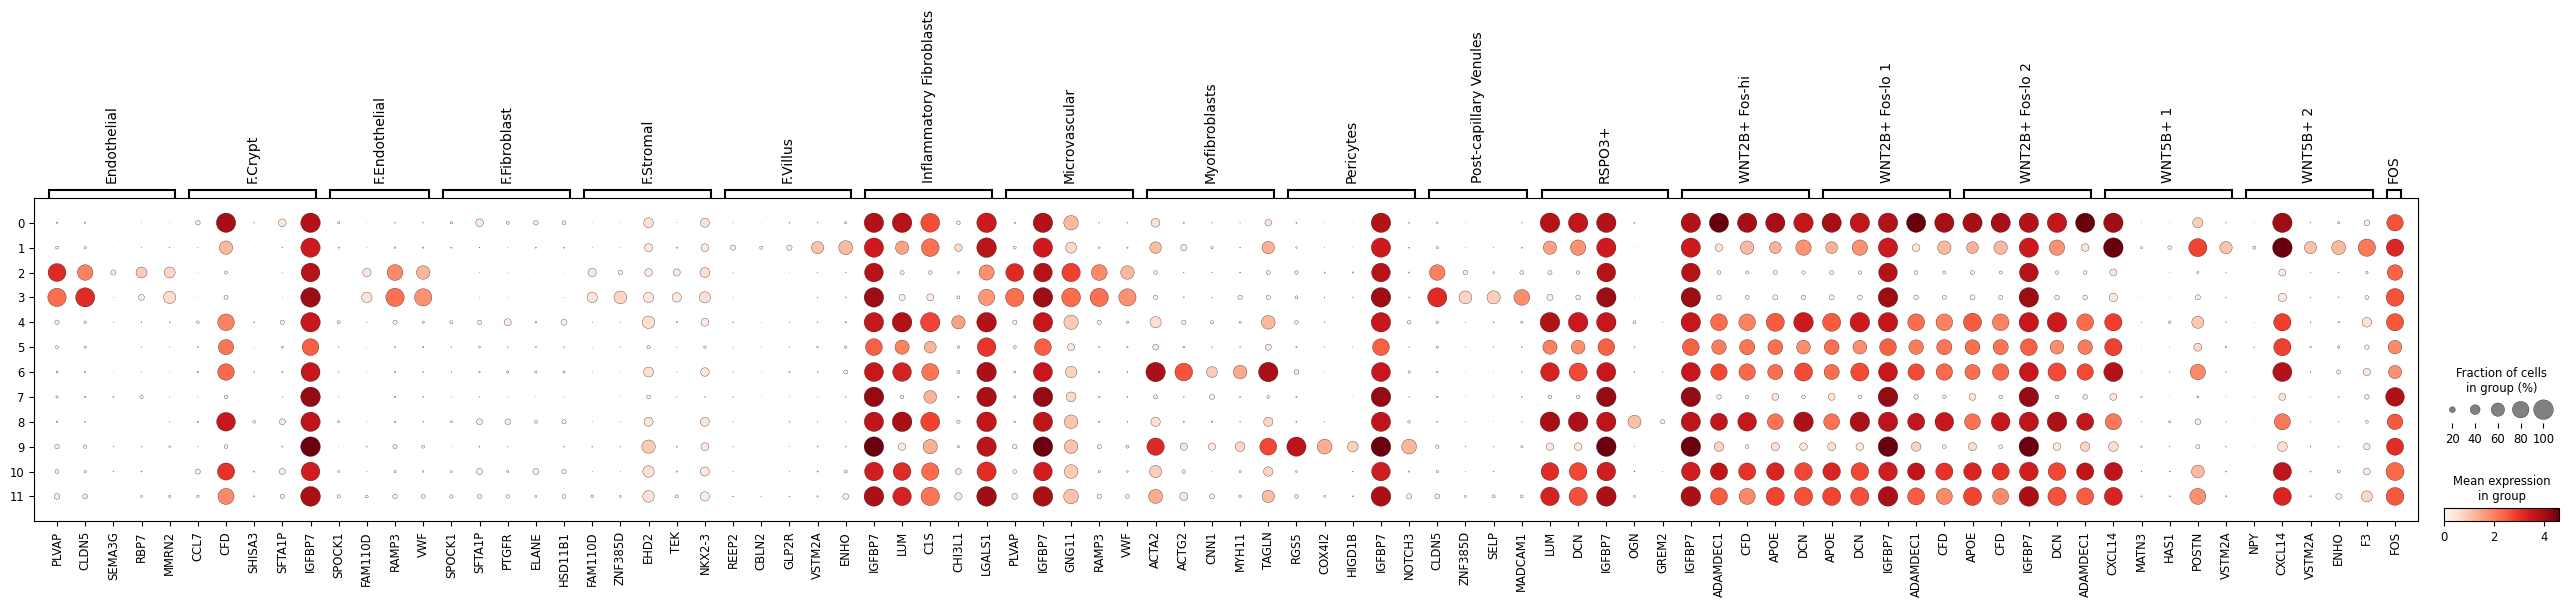

In [23]:
sc.pl.dotplot(adata_combined, marker_genes, 'leiden', use_raw=True)

sc.pl.heatmap(adata_combined,  smillie_kinchen_marker_genes, 'celltype', show_gene_labels=True, save='smillie+kinchen_marker_genes.png')

In [24]:
colon_marker_genes = {
    'glial': ['SOX10', 'PLP1', 'S100B'],
    'pericytes': ['RGS5'],
    'plasma cells': ['SDC1'],
    'stromal 1': ['APOE', 'CCL8', 'FABP5', 'ADAMDEC1'],
    'stromal 2': ['SOX6', 'VSTM2A', 'ID1', 'POSTN'],
    'stromal 3': ['KLF4', 'ID2', 'GREM1', 'OGN'],
    'stromal 4': ['ICAM1', 'IRF8', 'TNFSF13B', 'CCL19', 'IL32', 'C3'],
    'myofibroflasts': ['TAGLN', 'ACTA2', 'FLNA', 'TCEAL1'],
    'pan-fibroflast marker genes': ['VIM', 'COL1A2', 'COL3A1'],
    'IL11 related': ['IL11', 'IL11RA', 'IL6ST']
}

In [25]:
smillie_kinchen_marker_genes = {
    'Endothelial': ['PLVAP', 'CLDN5', 'SEMA3G', 'RBP7', 'MMRN2'],
 'F.Crypt': ['CCL7', 'CFD', 'SHISA3', 'SFTA1P', 'IGFBP7'],
 'F.Endothelial': ['SPOCK1', 'FAM110D', 'RAMP3', 'VWF'],
 'F.Fibroblast': ['SPOCK1', 'SFTA1P', 'PTGFR', 'ELANE', 'HSD11B1'],
 'F.Stromal': ['FAM110D', 'ZNF385D', 'EHD2', 'TEK', 'NKX2-3'],
 'F.Villus': ['REEP2', 'CBLN2', 'GLP2R', 'VSTM2A', 'ENHO'],
 'Inflammatory Fibroblasts': ['IGFBP7', 'LUM', 'C1S', 'CHI3L1', 'LGALS1'],
 'Microvascular': ['PLVAP', 'IGFBP7', 'GNG11', 'RAMP3', 'VWF'],
 'Myofibroblasts': ['ACTA2', 'ACTG2', 'CNN1', 'MYH11', 'TAGLN'],
 'Pericytes': ['RGS5', 'COX4I2', 'HIGD1B', 'IGFBP7', 'NOTCH3'],
 'Post-capillary Venules': ['CLDN5', 'ZNF385D', 'SELP', 'MADCAM1'],
 'RSPO3+': ['LUM', 'DCN', 'IGFBP7', 'OGN', 'GREM2'],
 'WNT2B+ Fos-hi': ['IGFBP7', 'ADAMDEC1', 'CFD', 'APOE', 'DCN'],
 'WNT2B+ Fos-lo 1': ['APOE', 'DCN', 'IGFBP7', 'ADAMDEC1', 'CFD'],
 'WNT2B+ Fos-lo 2': ['APOE', 'CFD', 'IGFBP7', 'DCN', 'ADAMDEC1'],
 'WNT5B+ 1': ['CXCL14', 'MATN3', 'HAS1', 'POSTN', 'VSTM2A'],
 'WNT5B+ 2': ['NPY', 'CXCL14', 'VSTM2A', 'ENHO', 'F3'],
 'FOS': ['FOS'],
    'glial': ['SOX10', 'PLP1', 'S100B'],
    'pericytes': ['RGS5'],
    'plasma cells': ['SDC1'],
    'stromal 1': ['APOE', 'CCL8', 'FABP5', 'ADAMDEC1'],
    'stromal 2': ['SOX6', 'VSTM2A', 'ID1', 'POSTN'],
    'stromal 3': ['KLF4', 'ID2', 'GREM1', 'OGN'],
    'stromal 4': ['ICAM1', 'IRF8', 'TNFSF13B', 'CCL19', 'IL32', 'C3'],
    'myofibroflasts': ['TAGLN', 'ACTA2', 'FLNA', 'TCEAL1'],
    'pan-fibroflast marker genes': ['VIM', 'COL1A2', 'COL3A1'],
    'IL11 related': ['IL11', 'IL11RA', 'IL6ST']
}

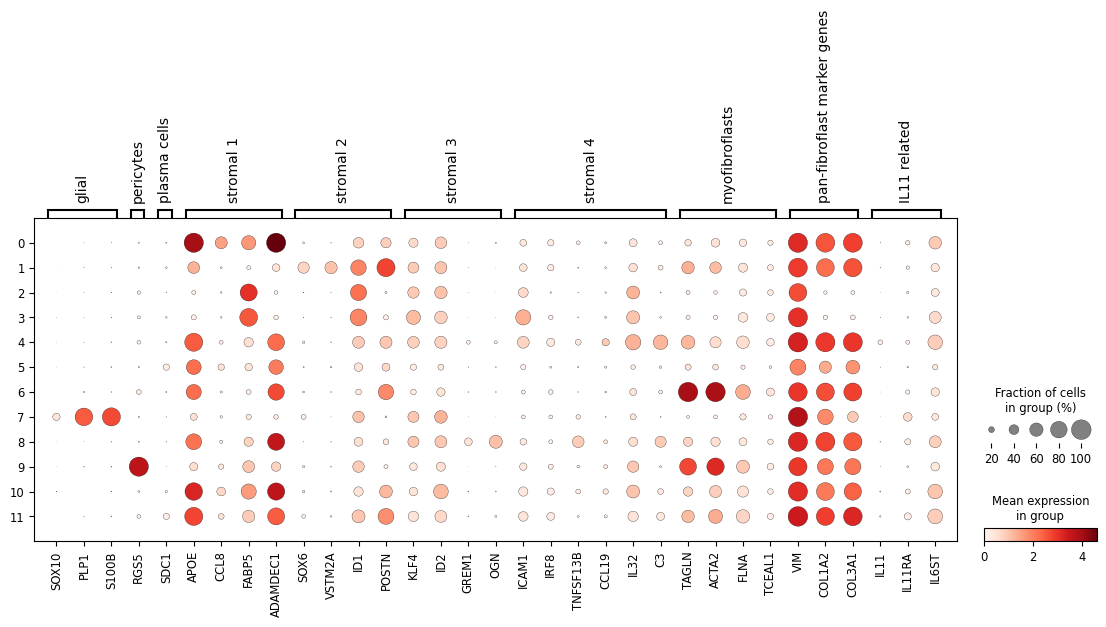

In [64]:
sc.pl.dotplot(adata_combined, colon_marker_genes, 'leiden', use_raw=True, save='all_cells_kinchen')

In [25]:
leiden_to_celltype = {
    '0': 'fibroblast 1',
    '1': 'fibroblast 2',
    '2': 'endothelial',
    '3': 'post-capillary venules',
    '4': 'inflammatory fibroblasts',
    '5': 'stromal 1',
    '6': 'myofibroflasts',
    '7': 'glial ',
    '8': 'fibroblast 1',
    '9': 'pericytes',
    '10': 'fibroblast 3',
    '11': 'fibroblast 4',
}

sc.pl.dotplot(adata_combined, ['IL11RA', 'IL6ST'], 'celltype', save='all_cell_IL11_receptors.png')

In [26]:
adata_combined.obs['celltype'] = adata_combined.obs['leiden'].map(leiden_to_celltype)

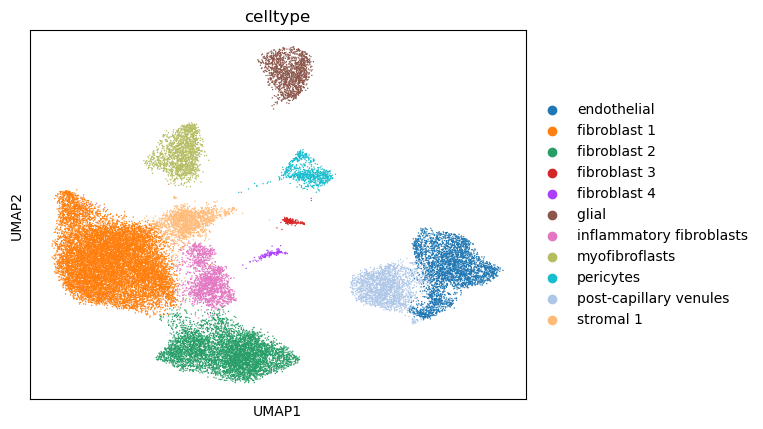

In [27]:
sc.pl.umap(adata_combined, color=['celltype'], use_raw=True)

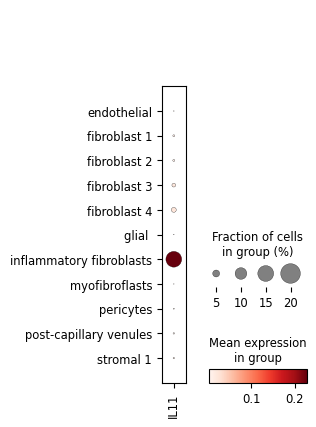

In [30]:
sc.pl.dotplot(adata_combined, 'IL11', 'celltype', save='IL11')

In [96]:
actable = get_deg_table_with_cluster_column(adata_combined, groupby='celltype')

In [97]:
actable

,group,gene,log2FoldChange,stat,pvalue,padj
0,endothelial,PLVAP,6.597280,79.237167,0.000000e+00,0.000000e+00
1,endothelial,RAMP2,5.358461,78.130768,0.000000e+00,0.000000e+00
2,endothelial,IFI27,3.571526,77.141815,0.000000e+00,0.000000e+00
3,endothelial,GNG11,3.108982,73.574188,0.000000e+00,0.000000e+00
4,endothelial,CD320,5.257568,72.207329,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...
187798,stromal 1,ANXA2,-2.092500,-29.974936,2.082635e-197,7.111366e-194
187799,stromal 1,ACTB,-1.751561,-31.897823,2.862166e-223,1.221644e-219
187800,stromal 1,HLA-A,-1.804957,-32.396221,3.102526e-230,1.765647e-226
187801,stromal 1,ITM2B,-1.959512,-33.332863,1.290601e-243,1.101722e-239


In [98]:
acdict={}
for celltype in actable['group'].unique():
    acdict[celltype] = actable.loc[actable['group'] == celltype, 'gene'].head(5).tolist()

In [99]:
acdict

{'endothelial': ['PLVAP', 'RAMP2', 'IFI27', 'GNG11', 'CD320'],
 'fibroblast 1': ['ADAMDEC1', 'CFD', 'DCN', 'APOE', 'LUM'],
 'fibroblast 2': ['F3', 'HSD17B2', 'POSTN', 'FRZB', 'NSG1'],
 'fibroblast 3': ['RPLP1', 'CD52', 'RPLP2', 'TPT1', 'RPS12'],
 'fibroblast 4': ['KIAA0101', 'STMN1', 'H2AFZ', 'TYMS', 'TK1'],
 'glial ': ['CRYAB', 'CD9', 'CLU', 'S100B', 'GPM6B'],
 'inflammatory fibroblasts': ['CTSK', 'BGN', 'C3', 'CXCL1', 'SOD2'],
 'myofibroflasts': ['TAGLN', 'ACTA2', 'MYL9', 'ACTG2', 'MYL6'],
 'pericytes': ['RGS5', 'NDUFA4L2', 'MYL9', 'ACTA2', 'COX4I2'],
 'post-capillary venules': ['CLDN5', 'CD74', 'RAMP3', 'NPC2', 'HLA-DRB1'],
 'stromal 1': ['IGHA1', 'MZB1', 'SSR4', 'AL928768.3', 'DERL3']}

In [67]:
IL_list = pd.read_csv('group-602.csv')

In [68]:
IL_list = np.array(IL_list.loc[:, 'Approved symbol']) 

In [69]:
IL_list = np.append(IL_list, ['IFNAR1', 'IFNAR2', 'IFNGR1', 'IFNGR2', 'IFNLR1'])

In [70]:
IL_list = IL_list [~np.isin(IL_list, ['CXCR1', 'CXCR2', 'IL12RB2', 'IL1RAPL2', 'IL22RA2', 'IL9R'])]

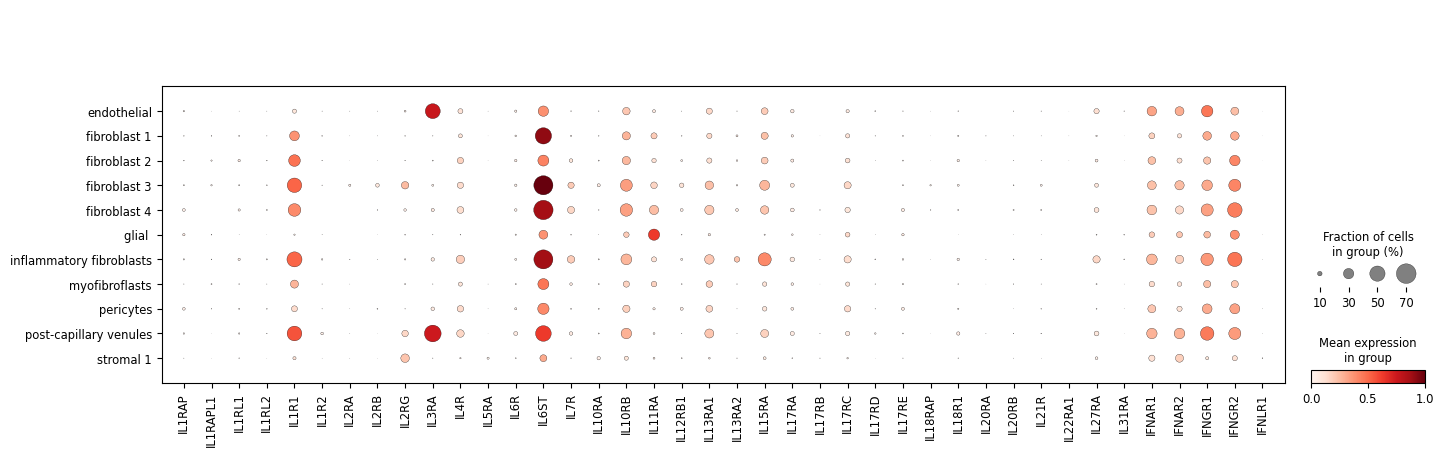

In [71]:
sc.pl.dotplot(adata_combined, IL_list, 'celltype', save='all_cells_IL_receptors')

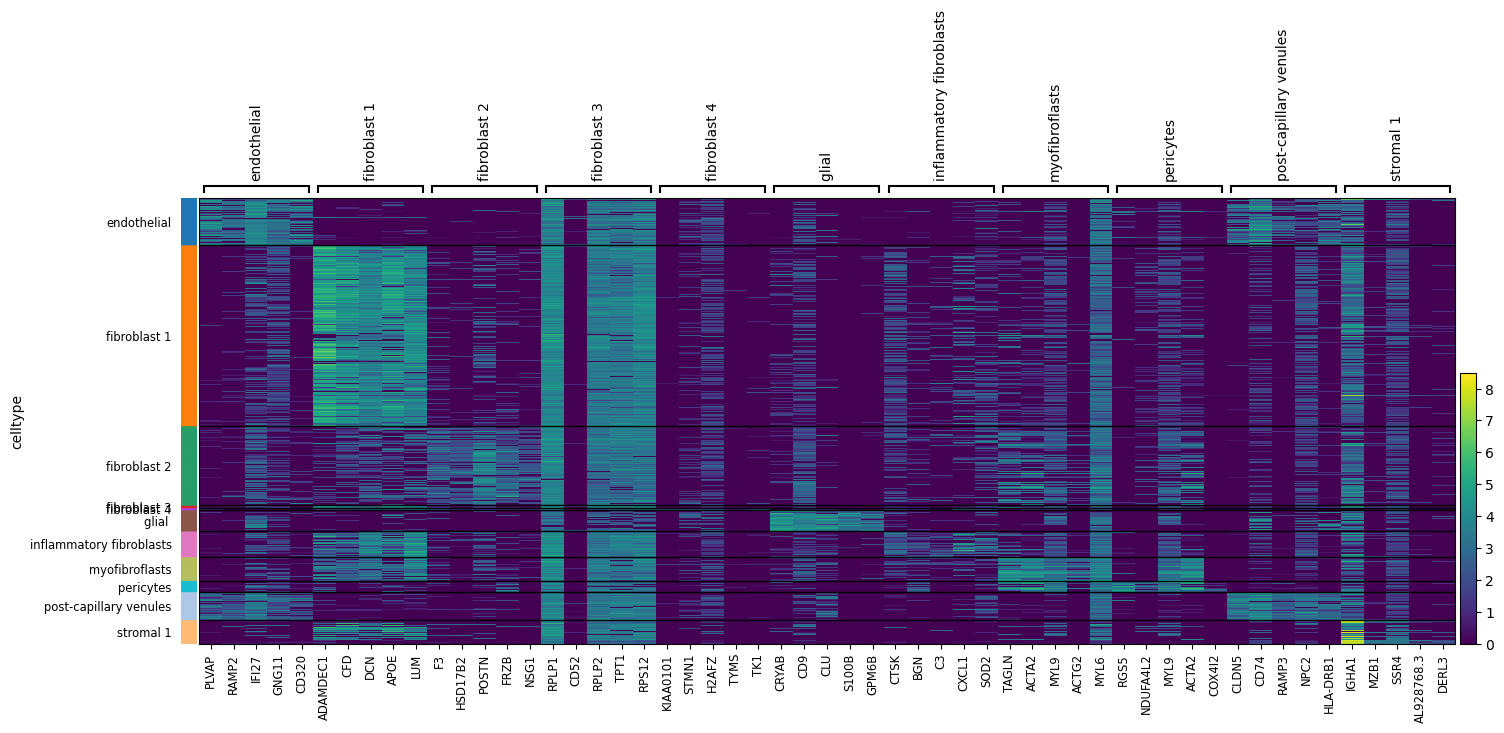

In [100]:
sc.pl.heatmap(adata_combined,  acdict, 'celltype', show_gene_labels=True, save='all_cells_heatmap')

sc.pl.umap(adata_combined, color='condition', use_raw=True, cmap=custom_cmap1, save='condition.png')

In [ ]:
sc.pl.umap(adata_combined, color=['IL11', 'SOX10', 'S100B'], use_raw=True, cmap=custom_cmap1)

In [ ]:
sc.pl.dotplot(adata_combined, 'IL11', 'celltype')

sc.pl.umap(adata_combined, color=['IL11RA', 'IL6ST'], use_raw=True, cmap=custom_cmap1, save='IL11_receptor.png')

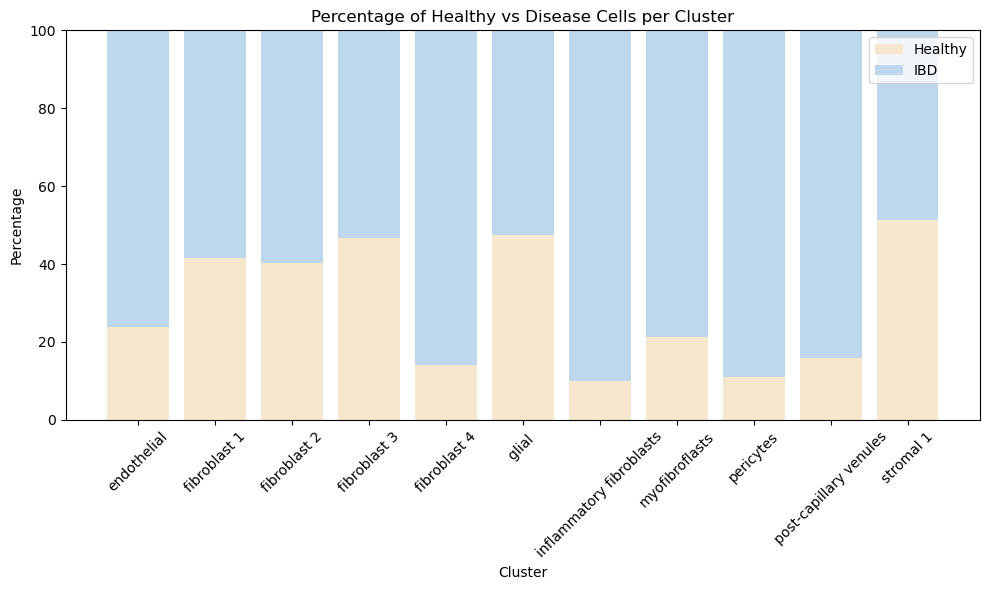

In [72]:
condition_stacked_bar_plot(adata_combined, 'celltype', 'condition', save='healthy_ibd_barplot.pdf')

In [33]:
gbarcodes = adata_combined[adata_combined.obs['leiden'] == '7'].obs_names

In [34]:
gadata = sc.concat([adata1, adata2], 
                           label='study', 
                           keys=['Kinchen et al. (2018)', 'Smillie et al. (2019)'],)

In [35]:
gadata.var['mt'] = gadata.var_names.str.startswith("MT")
sc.pp.calculate_qc_metrics(
    gadata,
    qc_vars=['mt'],
    percent_top=None,
    log1p=False,
    inplace=True
)

In [36]:
gadata = gadata[gadata.obs['pct_counts_mt']<5]
sc.pp.filter_genes(gadata, min_cells=10)
sc.pp.log1p(gadata)

/home/nim-lab/miniconda3/envs/dow3/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [37]:
gadata = gadata[gadata.obs_names.isin(gbarcodes)]

In [38]:
sc.pp.highly_variable_genes(
    gadata,
    flavor='seurat',
    batch_key='batch',
    n_top_genes=2500
)
gadata.raw = gadata.copy()
gadata = gadata[:, gadata.var.highly_variable].copy()

/home/nim-lab/miniconda3/envs/dow3/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:691: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  df = _highly_variable_genes_batched(
/home/nim-lab/miniconda3/envs/dow3/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:307: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/home/nim-lab/miniconda3/envs/dow3/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:691: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  df = _highly_variable_genes_batched(
/home/nim-lab/miniconda3/envs/dow3/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:703: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


/home/nim-lab/miniconda3/envs/dow3/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


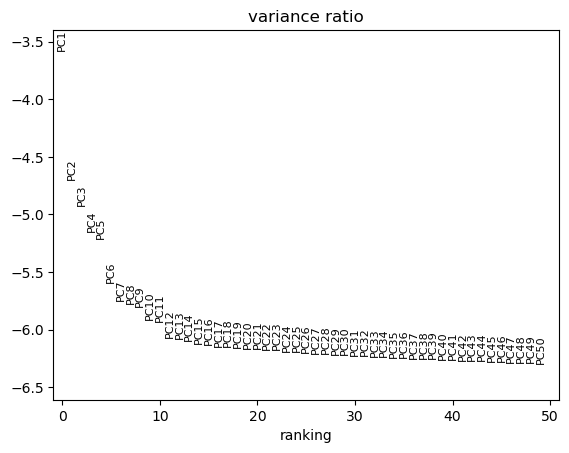

In [39]:
sc.pp.scale(gadata, max_value=10)
sc.tl.pca(gadata, svd_solver='arpack')
sc.pl.pca_variance_ratio(gadata, log=True, n_pcs = 50)

In [40]:
sc.external.pp.harmony_integrate(gadata, key='batch')
sc.pp.neighbors(gadata, n_neighbors = 20, n_pcs = 20, use_rep='X_pca_harmony')
sc.tl.umap(gadata)

2025-07-02 15:27:05,042 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-07-02 15:27:05,117 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-07-02 15:27:05,123 - harmonypy - INFO - Iteration 1 of 10
2025-07-02 15:27:05,261 - harmonypy - INFO - Iteration 2 of 10
2025-07-02 15:27:05,400 - harmonypy - INFO - Iteration 3 of 10
2025-07-02 15:27:05,503 - harmonypy - INFO - Iteration 4 of 10
2025-07-02 15:27:05,590 - harmonypy - INFO - Iteration 5 of 10
2025-07-02 15:27:05,687 - harmonypy - INFO - Iteration 6 of 10
2025-07-02 15:27:05,773 - harmonypy - INFO - Iteration 7 of 10
2025-07-02 15:27:05,849 - harmonypy - INFO - Iteration 8 of 10
2025-07-02 15:27:05,912 - harmonypy - INFO - Iteration 9 of 10
2025-07-02 15:27:05,965 - harmonypy - INFO - Iteration 10 of 10
2025-07-02 15:27:06,018 - harmonypy - INFO - Stopped before convergence


In [41]:
sc.tl.leiden(gadata, resolution=0.6)

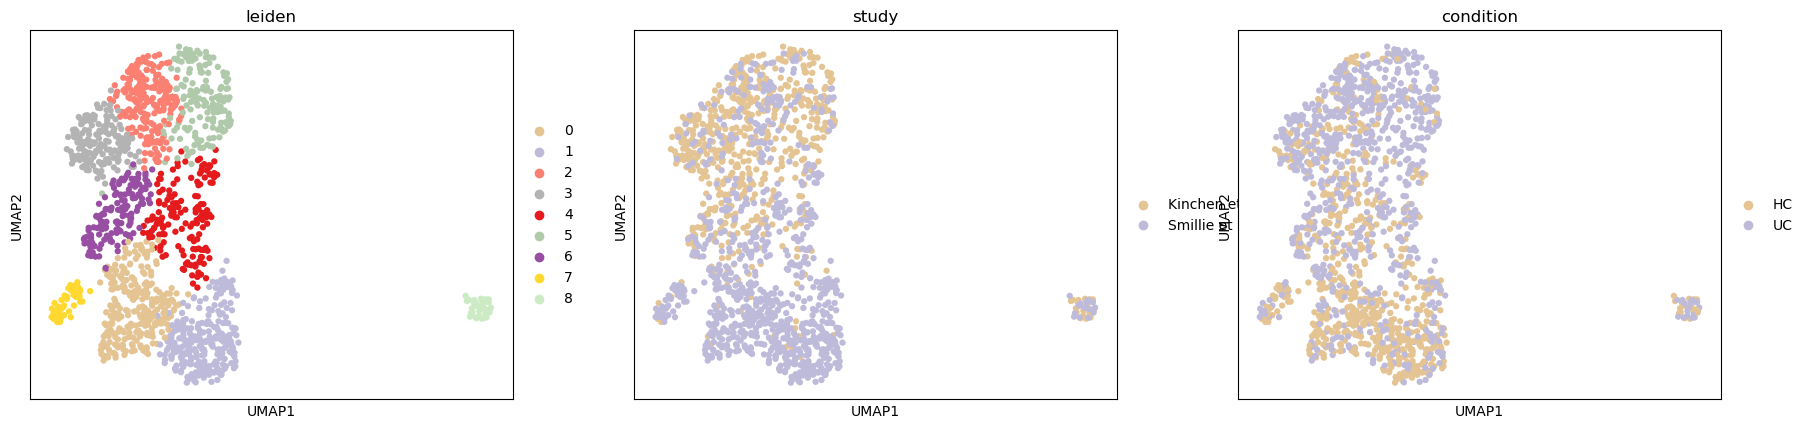

In [42]:
sc.pl.umap(gadata, color=['leiden', 'study', 'condition'], use_raw=True, palette = ['#E5C494', '#BEBADA', '#FB8072', '#B3B3B3', '#E41A1C', '#B0C9AA', '#984EA3', '#FFD92F', '#CCEBC5'])

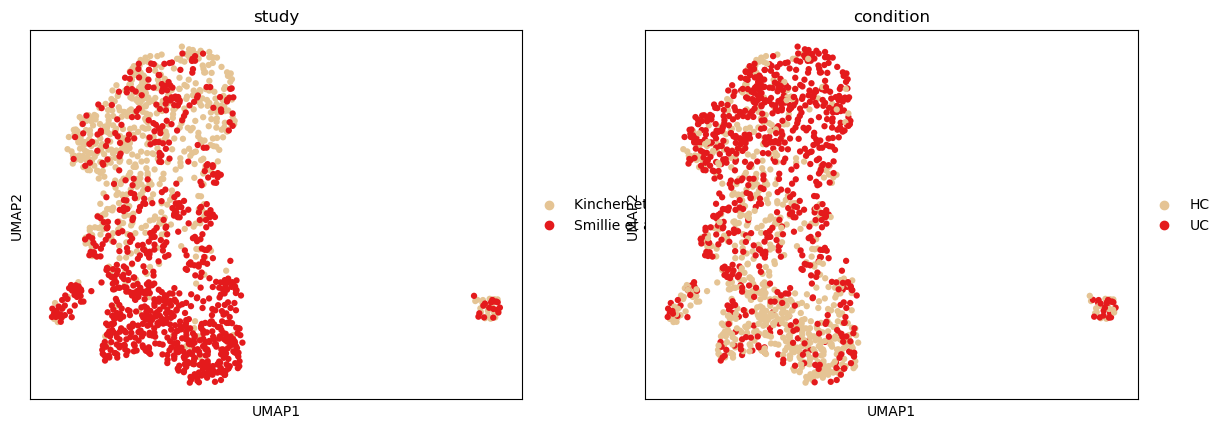

In [43]:
sc.pl.umap(gadata, color=['study', 'condition'], palette=['#E5C494', '#E41A1C'])

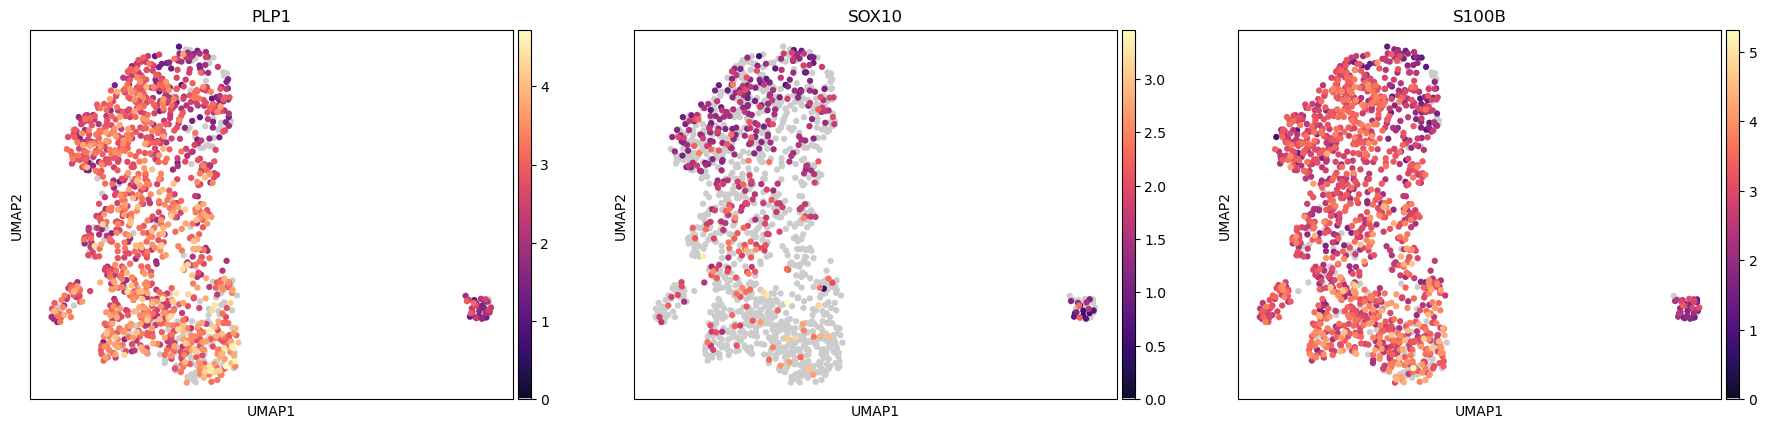

In [44]:
sc.pl.umap(gadata, color=['PLP1', 'SOX10', 'S100B'], cmap=custom_cmap1)

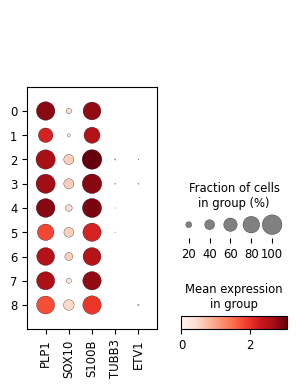

In [45]:
sc.pl.dotplot(gadata, ['PLP1', 'SOX10', 'S100B', 'TUBB3', 'ETV1'], 'leiden')

In [ ]:
sc.pl.dotplot(gadata, IL_list, 'leiden', save='glia_IL_receptors.png')

In [ ]:
condition_stacked_bar_plot(gadata, 'leiden', 'condition', save='glia_healthy_ibd_barplot.png')

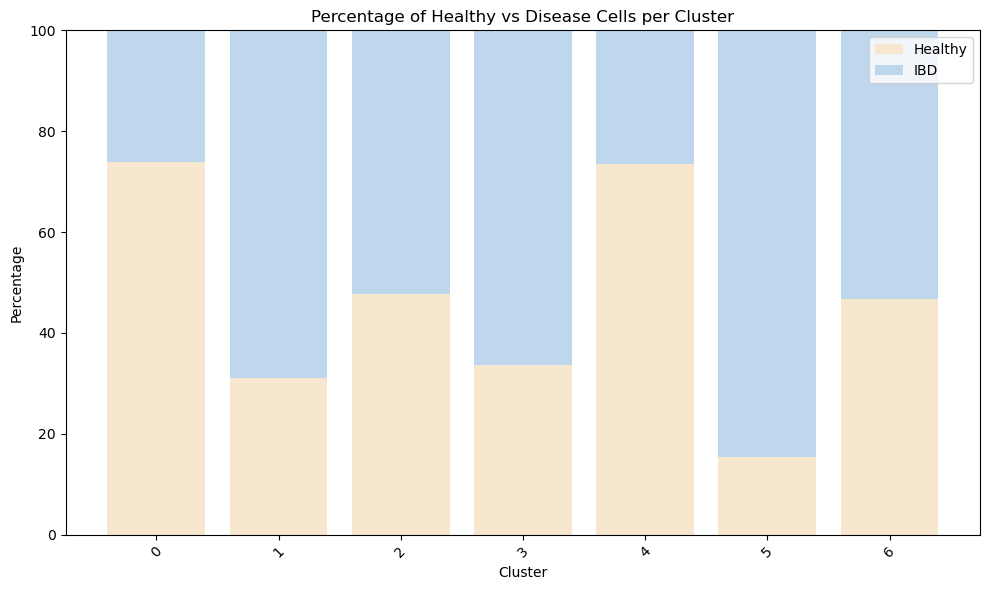

In [79]:
condition_stacked_bar_plot(ggadata, 'leiden', 'condition', save='glia_barplot.pdf')

In [ ]:
sc.tl.rank_genes_groups(gadata, groupby='leiden', method='wilcoxon', use_raw=True)

In [ ]:
sc.get.rank_genes_groups_df(gadata, group='0', pval_cutoff=None)

In [108]:
for cluster in gadata.obs['leiden'].unique(): 
    table = get_deg_table(gadata, groupby='leiden', cluster=cluster)
    table.to_csv(f'deg_human_colon_glia_cluster_{cluster}.csv', index=False)

In [ ]:
sc.pl.umap(gadata, color=['IL11RA', 'IL6ST'], use_raw=True, cmap=custom_cmap1, save='glia_IL11_receptors.png')

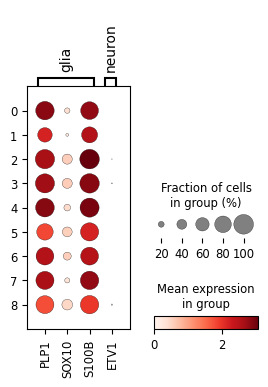

In [56]:
sc.pl.dotplot(gadata, {
    'glia': ['PLP1', 'SOX10', 'S100B'],
    'neuron': ['ETV1']
}, 'leiden', use_raw=True)

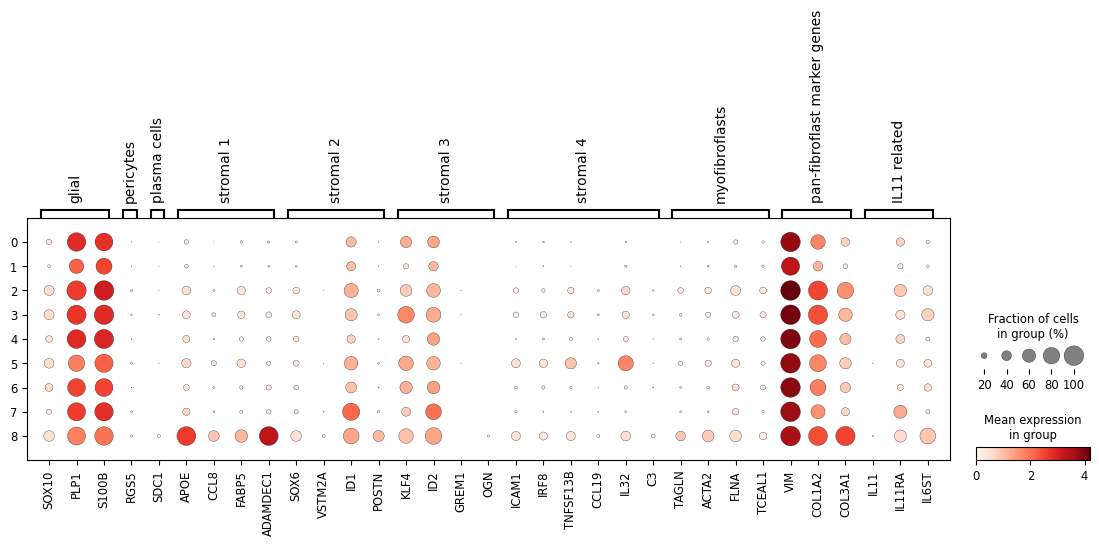

In [29]:
sc.pl.dotplot(gadata, colon_marker_genes, 'leiden', use_raw=True)

In [46]:
mask = gadata.obs['leiden'] == '8'
ggbarcodes = gadata[~mask].obs_names

In [47]:
ggbarcodes

Index(['AAACCTGGTGTAATGA-S66', 'AAAGATGGTCATCCCT-S66', 'AAAGTAGCATCTCGCT-S66',
       'AAATGCCTCAACACGT-S66', 'AATCCAGGTCCGAATT-S66', 'ACATCAGTCGCGTAGC-S66',
       'ACCCACTCATGCATGT-S66', 'ACGATGTAGAGTACCG-S66', 'ACGGGCTGTCGAATCT-S66',
       'ACGGGTCCAACTGGCC-S66',
       ...
       'N110.LPB.ATTACTCTCATAAAGG', 'N110.LPB.CACTCCACAATGGAAT',
       'N110.LPB.CCATGTCTCAGCGATT', 'N110.LPB.CGTCACTCACAAGCCC',
       'N110.LPB.CTCCTAGCACACCGCA', 'N110.LPB.GCAGCCAGTCCAGTTA',
       'N110.LPB.GTGAAGGCACCCATGG', 'N110.LPB.GTGCATACATAGAAAC',
       'N110.LPB.TGACAACCACATGGGA', 'N110.LPB.TGCCCATTCGGCGGTT'],
      dtype='object', length=1420)

In [48]:
ggadata = sc.concat([adata1, adata2], 
                           label='study', 
                           keys=['Kinchen et al. (2018)', 'Smillie et al. (2019)'],)

In [49]:
ggadata.var['mt'] = ggadata.var_names.str.startswith("MT")
sc.pp.calculate_qc_metrics(
    ggadata,
    qc_vars=['mt'],
    percent_top=None,
    log1p=False,
    inplace=True
)

In [50]:
ggadata = ggadata[ggadata.obs['pct_counts_mt']<5]
sc.pp.filter_genes(ggadata, min_cells=10)
sc.pp.log1p(ggadata)

/home/nim-lab/miniconda3/envs/dow3/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [51]:
ggadata = ggadata[ggadata.obs_names.isin(ggbarcodes)]

In [52]:
sc.pp.highly_variable_genes(
    ggadata,
    flavor='seurat',
    batch_key='batch',
    n_top_genes=2500
)
ggadata.raw = ggadata.copy()
ggadata = ggadata[:, ggadata.var.highly_variable].copy()

/home/nim-lab/miniconda3/envs/dow3/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:691: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  df = _highly_variable_genes_batched(
/home/nim-lab/miniconda3/envs/dow3/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:307: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/home/nim-lab/miniconda3/envs/dow3/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:691: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  df = _highly_variable_genes_batched(
/home/nim-lab/miniconda3/envs/dow3/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:703: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


/home/nim-lab/miniconda3/envs/dow3/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


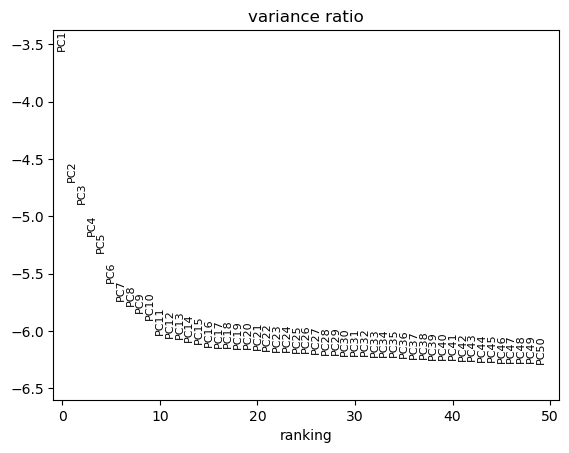

In [53]:
sc.pp.scale(ggadata, max_value=10)
sc.tl.pca(ggadata, svd_solver='arpack')
sc.pl.pca_variance_ratio(ggadata, log=True, n_pcs = 50)

In [54]:
sc.external.pp.harmony_integrate(ggadata, key='batch')
sc.pp.neighbors(ggadata, n_neighbors = 20, n_pcs = 20, use_rep='X_pca_harmony')
sc.tl.umap(ggadata)

2025-07-02 15:27:17,949 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-07-02 15:27:18,031 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-07-02 15:27:18,037 - harmonypy - INFO - Iteration 1 of 10
2025-07-02 15:27:18,171 - harmonypy - INFO - Iteration 2 of 10
2025-07-02 15:27:18,303 - harmonypy - INFO - Iteration 3 of 10
2025-07-02 15:27:18,408 - harmonypy - INFO - Iteration 4 of 10
2025-07-02 15:27:18,479 - harmonypy - INFO - Iteration 5 of 10
2025-07-02 15:27:18,551 - harmonypy - INFO - Iteration 6 of 10
2025-07-02 15:27:18,655 - harmonypy - INFO - Iteration 7 of 10
2025-07-02 15:27:18,716 - harmonypy - INFO - Iteration 8 of 10
2025-07-02 15:27:18,787 - harmonypy - INFO - Iteration 9 of 10
2025-07-02 15:27:18,853 - harmonypy - INFO - Iteration 10 of 10
2025-07-02 15:27:18,908 - harmonypy - INFO - Stopped before convergence


In [55]:
sc.tl.leiden(ggadata, resolution=0.6)

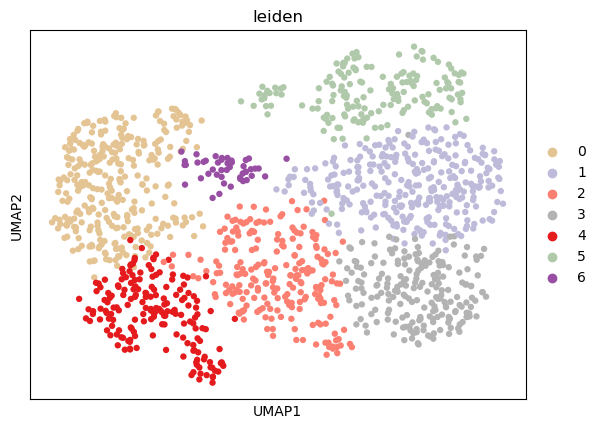

In [73]:
sc.pl.umap(ggadata, color=['leiden'], use_raw=True, palette = ['#E5C494', '#BEBADA', '#FB8072', '#B3B3B3', '#E41A1C', '#B0C9AA', '#984EA3', '#FFD92F', '#CCEBC5'], save='glia_leiden')

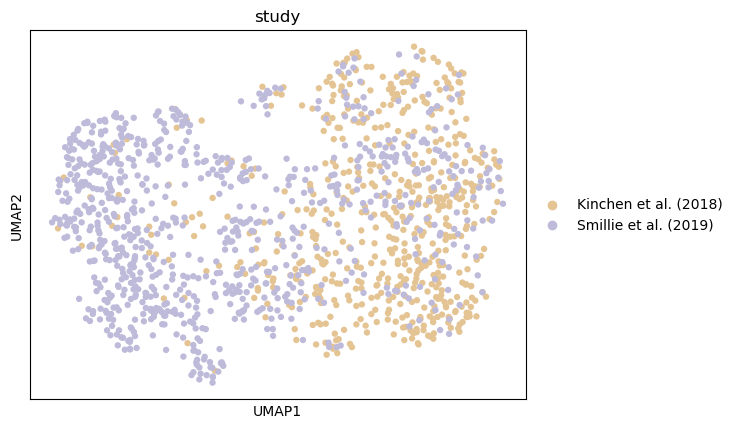

In [74]:
sc.pl.umap(ggadata, color=['study'], use_raw=True, palette = ['#E5C494', '#BEBADA', '#FB8072', '#B3B3B3', '#E41A1C', '#B0C9AA', '#984EA3', '#FFD92F', '#CCEBC5'], save='glia_study')

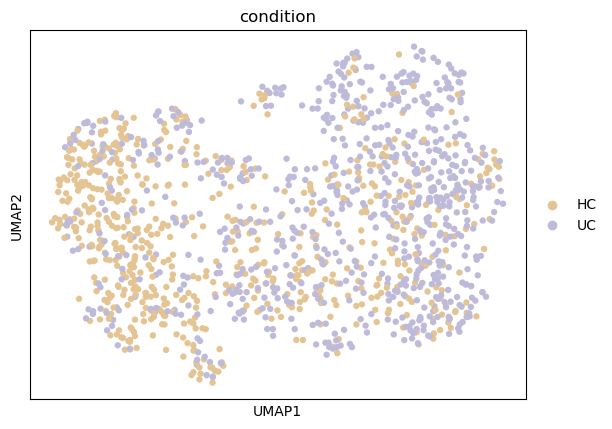

In [75]:
sc.pl.umap(ggadata, color=['condition'], use_raw=True, palette = ['#E5C494', '#BEBADA', '#FB8072', '#B3B3B3', '#E41A1C', '#B0C9AA', '#984EA3', '#FFD92F', '#CCEBC5'], save='glia_condition')

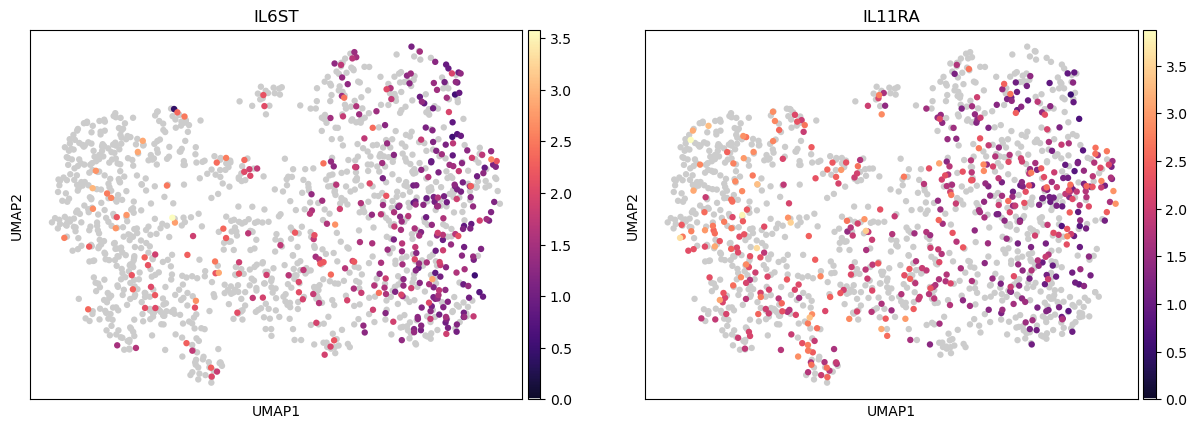

In [76]:
sc.pl.umap(ggadata, color=['IL6ST', 'IL11RA'], cmap=custom_cmap1, save='glia_IL11_receptors')

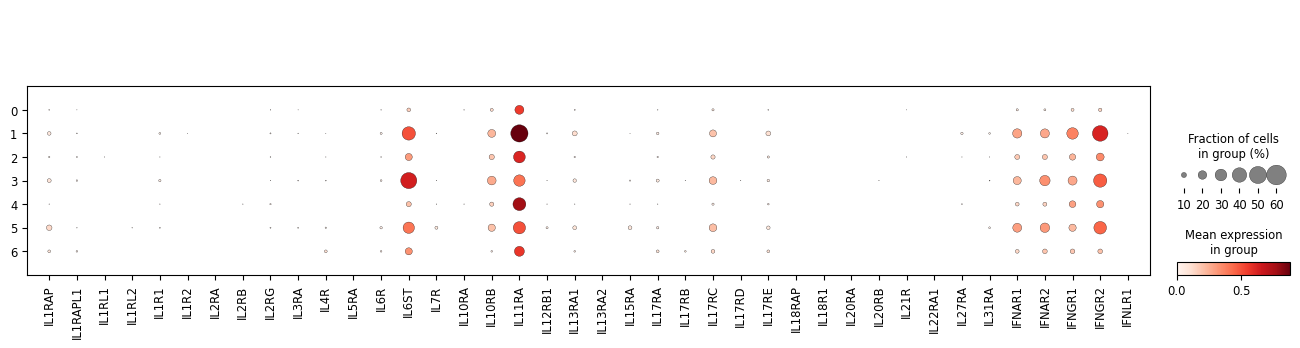

In [77]:
sc.pl.dotplot(ggadata, IL_list, 'leiden', use_raw=True, save='glia_IL_receptors')

In [59]:
for cluster in ggadata.obs['leiden'].unique(): 
    table = get_deg_table(ggadata, groupby='leiden', cluster=cluster)
    table.to_csv(f'deg/deg_human_colon_glia_cluster_{cluster}.csv', index=False)